In [ ]:
%%capture
!pip install speechbrain
!pip install pesq
!pip install mir_eval

In [ ]:
%%capture
import speechbrain
import librosa
import torchaudio
import torchaudio.transforms as T
import torch
import matplotlib.pyplot as plt

In [ ]:
%cd "/content/drive/Othercomputers/Mi portátil/projecte/StutterFormer/src"

/content/drive/Othercomputers/Mi portátil/projecte/StutterFormer/src


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
A100-SXM4-40GB


In [ ]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '12'
os.environ['NUMEXPR_NUM_THREADS'] = '12'

In [ ]:
!python train.py --device='cuda:0'

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ../out/tiny-stutterformer/2345
speechbrain.core - Info: noprogressbar arg from hparam file is used
speechbrain.core - 7.9M trainable parameters in StutterFormer
speechbrain.utils.checkpoints - Loading a checkpoint from ../out/tiny-stutterformer/2345/save/CKPT+2023-01-13+11-19-51+00
speechbrain.utils.epoch_loop - Going into epoch 97
100% 700/700 [51:39<00:00,  4.43s/it, train_loss=-1.03]
100% 150/150 [05:41<00:00,  2.27s/it]
speechbrain.utils.train_logger - epoch: 97, lr: 1.17e-06 - train loss: -1.03e+00 - valid loss: 1.44, valid pesq: 1.90, valid stoi: 7.29e-01
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in ../out/tiny-stutterformer/2345/save/CKPT+2023-01-13+15-02-03+00
speechbrain.utils.checkpoints - Deleted checkpoint in ../out/tiny-stutterformer/2345/save/CKPT+2023-01-13+11-19-51+00
speechbrain.utils.epoch_loop - Going into epoch 98
100% 700/700 [51:41<00:00,  4.43s/it, train_loss=-1.

In [ ]:
from speechbrain.pretrained import SepformerSeparation as separator
import IPython.display as ipd

STUTTER = '../data/LibriStutter/LibriStutter Audio/2836/5355/2836-5355-0029.flac'
SPEECH = '../data/LibriSpeech/2836/5355/2836-5355-0029.flac'
stutter_waveform, stutter_sr = torchaudio.load(STUTTER)
speech_waveform, speech_sr = torchaudio.load(SPEECH)

model = separator.from_hparams(
    source="../out/tiny-stutterformer/2345/save/best",
    savedir="/content/pretrained_models/tiny-stutterformer"
)

sources = model.separate_file(path=STUTTER)

In [ ]:
ipd.Audio(stutter_waveform, rate=16000)

In [ ]:
ipd.Audio(sources[:, :, 0], rate=16000)

In [ ]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

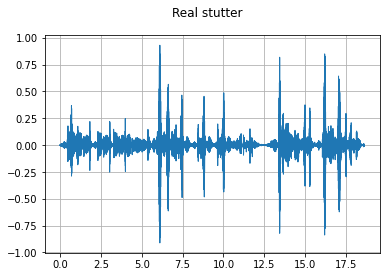

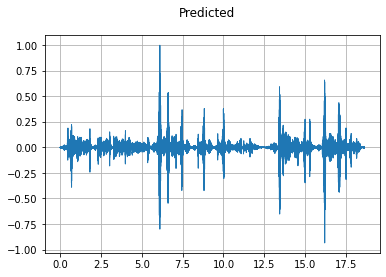

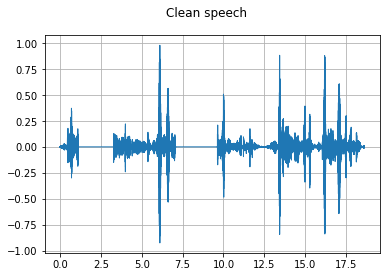

In [ ]:
plot_waveform(stutter_waveform, stutter_sr, title="Real stutter")
plot_waveform(sources[:, :, 0], stutter_sr, title="Predicted")
plot_waveform(speech_waveform, speech_sr, title="Clean speech")

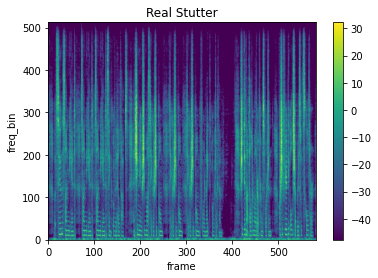

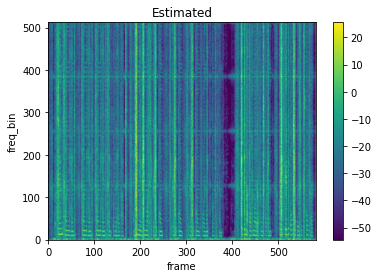

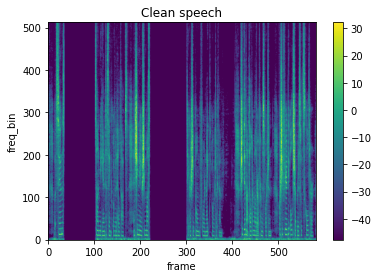

In [ ]:
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

stutter_spec = spectrogram(stutter_waveform)
plot_spectrogram(stutter_spec[0], title="Real Stutter")

estimated = spectrogram(sources[:, :, 0])
plot_spectrogram(estimated[0], title="Estimated")

speech_spec = spectrogram(speech_waveform)
plot_spectrogram(speech_spec[0], title="Clean speech")